# Description
The notations of the parameters used in this notebook are as followed:
- raw_df      = imported dataset
- data        = gathered samples
- target      = labels regarding each data
- scaled_data = Standardized data
- x_train     = data used for training the model
- y_train     = targets used for training the model
- x_test      = data used to test the model
- y_test      = targets used to test the model
- y_pred      = predicted targets by the model

# Parameter Selection

In [15]:
dataset_sel = 1   
# 0 for Boston Housing Price
# 1 for California Housing Price
# 2 for Tehran Housing Price
# 3 for Fuel Consumption

PairPlot = 0 # enable to visualize Pair-Plot
data_normalization = 1 # enable to normalize the raw data
outliers_removal = 1 # enable to remove the outliers
reg_model = 1
# 0 for Ridge Regression using Scikit-Learn
# 1 for Neural Network Regression using tensorflow

import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

# Load Library

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
if reg_model == 0:
    from sklearn.linear_model import Ridge
elif reg_model == 1:
    import os, time
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from keras_tuner import RandomSearch

# Load Dataset and Primary Data Preparation

In [3]:
if dataset_sel == 0:
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df_tmp = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df_tmp.values[::2, :], raw_df_tmp.values[1::2, :2]])
    raw_df = pd.DataFrame(data, columns=['Crime','ZN','INDUS','CHAS','nitric oxides','Rooms','Age','Distance','Accesibility','Tax','pupil-teacher','B',
                                         'Lower status'])
    raw_df["Price"]=raw_df_tmp.values[1::2, 2]
    data_end_index=-2
    target=raw_df.iloc[:,-1]
elif dataset_sel == 1:
    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()
    raw_df = pd.DataFrame(housing.data, columns=['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'])
    raw_df["Price"]=housing.target
    data_end_index=-2
    target=raw_df.iloc[:,-1]
elif dataset_sel == 2: 
    # dataset from github of Prof. Sharifzarchi
    data_url = 'https://github.com/mghadian/Machine-Learning/raw/main/housePrice.xlsx'
    raw_df_tmp = pd.read_excel(data_url, engine='openpyxl')
    raw_df_tmp = raw_df_tmp.drop('Price',axis=1)
    ## One Hot Encoding
    raw_df_tmp=pd.get_dummies(raw_df_tmp)
    column_to_move = 'PriceUSD'
    cols = [col for col in raw_df_tmp.columns if col != column_to_move] + [column_to_move]
    raw_df = raw_df_tmp.reindex(columns=cols)
    raw_df.iloc[:,-1] = raw_df.iloc[:,-1]*0.001
    data_end_index=-2
    target=raw_df.iloc[:,-1]
elif dataset_sel == 3:
    data_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv"
    raw_df_tmp = pd.read_csv(data_url)
    raw_df_tmp=pd.get_dummies(raw_df_tmp)
    column_to_move = ['FUELCONSUMPTION_CITY','FUELCONSUMPTION_HWY','FUELCONSUMPTION_COMB','FUELCONSUMPTION_COMB_MPG','CO2EMISSIONS']
    cols = [col for col in raw_df_tmp.columns if col not in column_to_move] + column_to_move
    raw_df = raw_df_tmp.reindex(columns=cols)
    data_end_index=-6
    target=raw_df.iloc[:,-5:]

# Data Preparation

## Data Normalization

In [4]:
if data_normalization == 1:
    zero_array = np.zeros((raw_df.shape[0],raw_df.shape[1]+data_end_index+1))
    scaled_data = pd.DataFrame(zero_array,columns=raw_df.columns[:data_end_index+1])
    for i in range(raw_df.shape[1]+data_end_index):
        if raw_df.iloc[:,i].std() != 0:
            if isinstance(raw_df.iloc[0,i], np.int64) and not isinstance(raw_df.iloc[0,i], bool):
                scaled_data.iloc[:,i] = (raw_df.iloc[:,i] - raw_df.iloc[:,i].mean()) / raw_df.iloc[:,i].std()
            else:
                scaled_data.iloc[:,i] = raw_df.iloc[:,i] 
        else:
            scaled_data.iloc[:,i] = raw_df.iloc[:,i]
else:
    scaled_data = raw_df.iloc[:,:data_end_index+1]

## Outliers Removal

In [5]:
if outliers_removal == 1:
    for i in range(scaled_data.shape[1]):
        if isinstance(scaled_data.iloc[0, i], (int, float, np.int64)) and not isinstance(scaled_data.iloc[0, i], bool):
            # Data cleaning - removing outliers based on IQR
            Q1_i = scaled_data.iloc[:,i].quantile(0.25)
            Q3_i = scaled_data.iloc[:,i].quantile(0.75)
            IQR_area = Q3_i - Q1_i
            
            lower_bound = Q1_i - 1.5 * IQR_area
            upper_bound = Q3_i + 1.5 * IQR_area
            
            scaled_data_tmp = scaled_data[(scaled_data.iloc[:,i] >= lower_bound) & (scaled_data.iloc[:,i] <= upper_bound)]
            target = target[(scaled_data.iloc[:,i] >= lower_bound) & (scaled_data.iloc[:,i] <= upper_bound)]
            scaled_data = scaled_data_tmp

# Visualization

In [6]:
scaled_data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,0.0
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,0.0
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,0.0
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,0.0
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,0.0
...,...,...,...,...,...,...,...,...
20634,3.7125,28.0,6.779070,1.148256,1041.0,3.026163,39.27,0.0
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,0.0
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,0.0
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,0.0


In [7]:
target

3        3.413
4        3.422
5        2.697
6        2.992
7        2.414
         ...  
20634    1.168
20635    0.781
20637    0.923
20638    0.847
20639    0.894
Name: Price, Length: 16813, dtype: float64

In [8]:
if PairPlot == 1:
    import seaborn as sns
    sns.pairplot(scaled_data)

## Principal Component Analysis

Explained Variance Ratio Using PCA is:  [9.99632982e-01 3.46888526e-04]


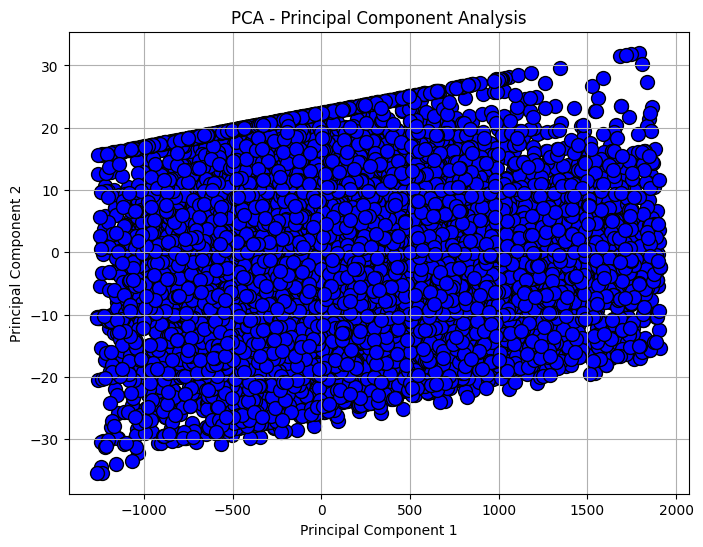

In [9]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=data_pca, columns=['PC1', 'PC2'])
print('Explained Variance Ratio Using PCA is: ',pca.explained_variance_ratio_)
# Visualizing the principal components
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c='blue', edgecolor='k', s=100)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - Principal Component Analysis')
plt.grid(True)
plt.show()

# Creation of Training & Test Data

In [10]:
x_train,x_test,y_train,y_test=train_test_split(scaled_data,target,test_size=0.3, random_state=42)

# Regression

## Regression Using SK-Learn

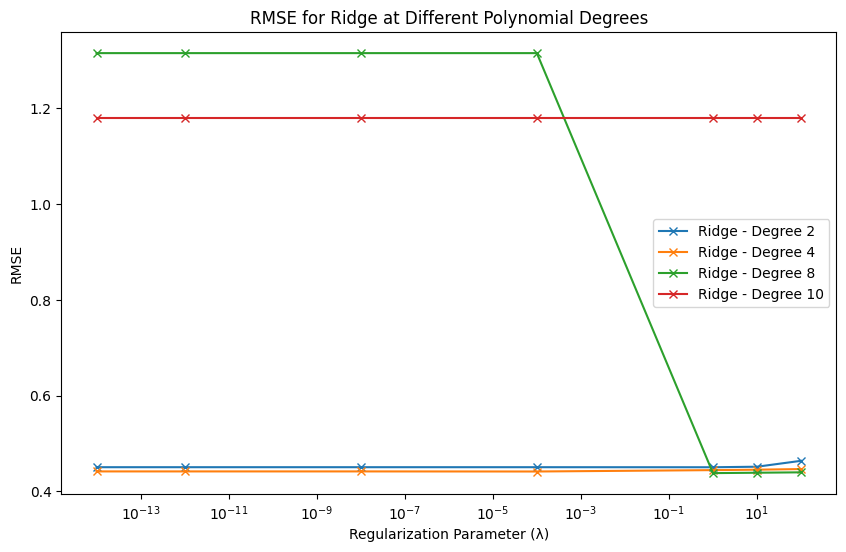

In [11]:
if reg_model == 0:

    def polynomial_features(X, degree):
        X_poly = np.c_[np.ones(len(X))]
        for i in range(1, degree + 1):
            X_poly = np.c_[X_poly, X**i]
        return X_poly
    
    degrees = [2, 4, 8, 10]
    lambdas = [100, 10, 1, 1e-4, 1e-8, 1e-12, 1e-14]
    ridge_rmse_train = np.zeros((len(degrees), len(lambdas)))
    ridge_rmse_test = np.zeros((len(degrees), len(lambdas)))
    
    for degree_idx, degree in enumerate(degrees):
        for lambda_idx, lambda_val in enumerate(lambdas):
            x_train_poly = polynomial_features(x_train,degree)
            x_test_poly = polynomial_features(x_test,degree)

            ridge_model = Ridge(alpha=lambda_val)
            ridge_model.fit(x_train_poly, y_train)
            y_train_pred_ridge = ridge_model.predict(x_train_poly)
            y_test_pred_ridge = ridge_model.predict(x_test_poly)
    
            ridge_rmse_train[degree_idx, lambda_idx] = mean_squared_error(y_train, y_train_pred_ridge)
            ridge_rmse_test[degree_idx, lambda_idx] = mean_squared_error(y_test, y_test_pred_ridge)
    
    # plot RMSE
    plt.figure(figsize=(10, 6))
    
    for degree_idx, degree in enumerate(degrees):
        plt.plot(lambdas, ridge_rmse_test[degree_idx], marker='x', label=f'Ridge - Degree {degree}')
    plt.xscale('log')
    plt.xlabel('Regularization Parameter (λ)')
    plt.ylabel('RMSE')
    plt.title('RMSE for Ridge at Different Polynomial Degrees')
    plt.legend()
    plt.show()
    
    m = np.unravel_index(np.argmin(ridge_rmse_test), ridge_rmse_test.shape)
    
    x_train_poly = polynomial_features(x_train,degrees[int(m[0])])
    x_test_poly = polynomial_features(x_test,degrees[int(m[0])])
    ridge_model = Ridge(alpha=lambdas[int(m[1])])
    ridge_model.fit(x_train_poly, y_train)
    y_pred = ridge_model.predict(x_test_poly)   

## Regression Using NN

In this section finding the hyper-parameters for NN is done for:
- input layer with `128 : 128 : 1024` nodes
- 1 to 4 hidden layers, each having `64 : 64 : 512` nodes
- output layer with target.shape[1] nodes
- Adam optimizer with learning rate between `1e-4 to 1e-2`

To view the optimum mode use `model.summary()`

In [19]:
if reg_model == 1:
    y_train = np.array(y_train)
    if y_train.ndim == 1:
        y_train = y_train.reshape(-1, 1)
        
    def build_model(hp, input_shape, output_shape):
        model = keras.Sequential(name=f'tuned_regression_model_{int(time.time())}')
        
        # Input layer with unique name
        model.add(keras.layers.Dense(
            units=hp.Int('input_units', 128, 1024, step=128),
            activation='relu',
            input_shape=(input_shape,),
            name=f'input_layer_{int(time.time())}'
        ))
        model.add(keras.layers.Dropout(0.2))
        
        # Hidden layers (1-4) with unique names
        for i in range(hp.Int('num_layers', 1, 4)):
            timestamp = int(time.time())
            model.add(keras.layers.Dense(
                units=hp.Int(f'hidden_units_{i}', 64, 512, step=64),
                activation='relu',
                name=f'hidden_layer_{i}_{timestamp}'
            ))
            model.add(keras.layers.Dropout(0.2))
        
        # Output layer with unique name
        model.add(keras.layers.Dense(output_shape, activation='linear',
            name=f'output_layer_{int(time.time())}'
        ))
        
        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'),
                name=f'adam_optimizer_{int(time.time())}'
            ),
            loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name=f'rmse_{int(time.time())}')]
        )
        
        return model
    
    def save_model(model, path='saved_model'):
        """Save model with proper directory creation"""
        try:
            os.makedirs(path, exist_ok=True)
            model.save(path, save_format='tf')
            print(f"Model successfully saved to {path}")
            return True
        except Exception as e:
            print(f"Error saving model: {e}")
            return False
    
    def load_model(path='saved_model'):
        """Load model with comprehensive custom objects"""
        custom_objects = {
            'Adam': keras.optimizers.Adam,
            'BatchNormalization': keras.layers.BatchNormalization,
            'RootMeanSquaredError': tf.keras.metrics.RootMeanSquaredError
        }
        
        try:
            model = keras.models.load_model(path, custom_objects=custom_objects)
            print("Model successfully loaded")
            return model
        except Exception as e:
            print(f"Error loading model: {e}")
            return None
    
    def train_and_tune(X, y, max_trials=30, epochs=50, model_save_path='saved_model'):
                
        # Initialize tuner
        tuner = RandomSearch(
            lambda hp: build_model(hp, x_train.shape[1], y_train.shape[1]),
            objective='val_loss', directory='tuning',
            max_trials=max_trials, project_name='regression_tuning',  
            overwrite=True)
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10, restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5, patience=5)
        ]
        
        # Perform hyperparameter search
        tuner.search(x_train, y_train, epochs=epochs,
            validation_split=0.2, callbacks=callbacks, verbose=1)
        
        # Get best model
        best_model = tuner.get_best_models(num_models=1)[0]
        
        # Save the best model
        save_success = save_model(best_model, model_save_path)
        
        # Evaluate
        evaluation = best_model.evaluate(x_test, y_test, verbose=0)
        metrics = {
            'loss': evaluation[0],
            'mae': evaluation[1],
            'rmse': evaluation[2] if len(evaluation) > 2 else None
        }
        
        print("\nEvaluation Results:")
        print(f"MSE: {metrics['loss']:.4f}")
        print(f"MAE: {metrics['mae']:.4f}")
        if metrics['rmse'] is not None:
            print(f"RMSE: {metrics['rmse']:.4f}")
        
        return best_model, metrics

    model, metrics = train_and_tune(x_train, y_train)
    
    # Make predictions
    y_pred = model.predict(x_test)

Trial 30 Complete [00h 01m 03s]
val_loss: 1.5965365171432495

Best val_loss So Far: 0.463958203792572
Total elapsed time: 01h 27m 05s
Error saving model: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf

Evaluation Results:
MSE: 0.4970
MAE: 0.5302
RMSE: 0.7050
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


# Performance Analysis

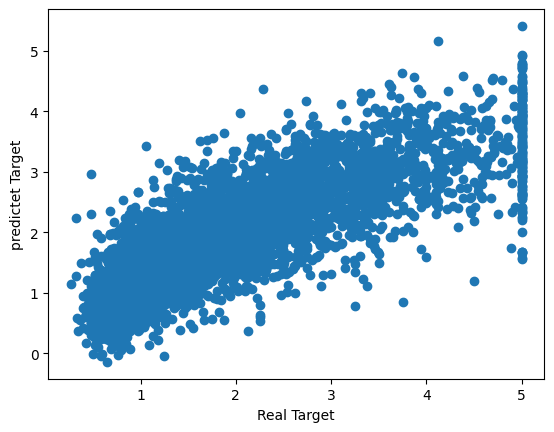

Regresion MSE is:  0.4381668131595193


In [14]:
    plt.scatter(y_test,y_pred)
    plt.xlabel('Real Target')
    plt.ylabel('predictet Target')
    plt.show()
    mse=mean_squared_error(y_test,y_pred)
    print("Regresion MSE is: ", mse)